In [ ]:
!pip3 install -q -U bitsandbytes==0.42.0
!pip3 install -q -U peft==0.8.2
!pip3 install -q -U trl==0.7.10
!pip3 install -q -U accelerate
!pip3 install -q -U datasets
!pip3 install -q -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 87.8 MB/s eta 0:00:00


In [ ]:
# taken reference from https://huggingface.co/blog/gemma-peft

from peft import LoraConfig

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

In [ ]:
lora_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='CAUSAL_LM', inference_mode=False, r=8, target_modules={'up_proj', 'down_proj', 'k_proj', 'v_proj', 'o_proj', 'q_proj', 'gate_proj'}, lora_alpha=8, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})

# Loading Models and Tokenizers

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import os
from google.colab import userdata


os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN_READ')
model_id = "google/gemma-2b-it"
bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16)

tokenizer = AutoTokenizer.from_pretrained(model_id, token=os.environ['HF_TOKEN'])
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map='auto', token=os.environ['HF_TOKEN'])

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Pre-processing

In [ ]:
from datasets import load_dataset

# taken reference from code of Independent Project at MIDAS Lab written by Chayan Tank at IIIT Delhi
data = load_dataset('csv', data_files = {'train':'/content/Horror Stories Train.csv',
                                  'validation':'/content/Horror Stories Val.csv',
                                  'test':'/content/Horror Stories Test.csv'})

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
training_data = data['train']
validation_data = data['validation']
testing_data = data['test']

In [ ]:
# taken reference from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c

def generate_prompt(data):
    prefix_text = 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\\n\\n'
    instruction = 'Generate a horror story given the beginning of the story: '
    if data['Prompt']:
        text = f"""<start_of_turn>user {prefix_text} {instruction} {data["Prompt"]} <end_of_turn>\\n<start_of_turn>model {data["Story"]} <end_of_turn>"""
    else:
        text = f"""<start_of_turn>user {prefix_text} {instruction} <end_of_turn>\\n<start_of_turn>model {data["Story"]} <end_of_turn>"""
    return text

training_text_column = []
for i in range(len(training_data)):
  training_text_column.append(generate_prompt(training_data[i]))

validation_text_column = []
for i in range(len(validation_data)):
  validation_text_column.append(generate_prompt(validation_data[i]))

testing_text_column = []
for i in range(len(testing_data)):
  testing_text_column.append(generate_prompt(testing_data[i]))

training_dataset = training_data.add_column("prompt", training_text_column)
validation_dataset = validation_data.add_column("prompt", validation_text_column)
testing_dataset = testing_data.add_column("prompt", testing_text_column)

In [ ]:
# len(testing_data['Prompt']), len(testing_data['Story'])

(15, 15)

In [ ]:
# taken reference from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c

training_tokens = training_dataset.map(lambda samples: tokenizer(samples["prompt"], max_length=1000), batched=True)
validation_tokens = validation_dataset.map(lambda samples: tokenizer(samples["prompt"], max_length=1000), batched=True)
testing_tokens = testing_dataset.map(lambda samples: tokenizer(samples["prompt"], max_length=1000), batched=True)

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

# Model Training

In [ ]:
!pip install git+https://github.com/huggingface/trl.git@7630f877f91c556d9e5a3baa4b6e2894d90ff84c

  Cloning https://github.com/huggingface/trl.git (to revision 7630f877f91c556d9e5a3baa4b6e2894d90ff84c) to /tmp/pip-req-build-ku1308hh
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/trl.git /tmp/pip-req-build-ku1308hh
  Running command git rev-parse -q --verify 'sha^7630f877f91c556d9e5a3baa4b6e2894d90ff84c'
  Running command git fetch -q https://github.com/huggingface/trl.git 7630f877f91c556d9e5a3baa4b6e2894d90ff84c
  Running command git checkout -q 7630f877f91c556d9e5a3baa4b6e2894d90ff84c
  Resolved https://github.com/huggingface/trl.git to commit 7630f877f91c556d9e5a3baa4b6e2894d90ff84c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for trl: filename=trl-0.7.12.dev0-py3-none-any.whl size=173433 sha256=161830084cb62754547a9ac8ba98cb5e902528eec9a8d3ae465e0b546a21a3f8
  Stored in directory: /root/.cache/pip/wheels/ad/f5/b1/f5ac48230936583c88cfde8

In [ ]:
import transformers
from trl import SFTTrainer

# taken reference from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c
tokenizer.pad_token = tokenizer.eos_token
model_trainer = SFTTrainer(
    model=model,
    train_dataset=training_tokens,
    eval_dataset=validation_tokens,
    dataset_text_field="prompt",
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        evaluation_strategy="epoch",
        gradient_accumulation_steps=4,
        warmup_steps=2,
        #max_steps=10,
        learning_rate=1e-4,
        fp16=True,
        logging_steps=1,
        output_dir="/content/drive/MyDrive/Story Generation Model Weights/horror_story",
        optim="paged_adamw_8bit",
        num_train_epochs=4,
        logging_strategy='epoch'
    ),
    peft_config=lora_config
)
model_trainer.train()

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:228: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,3.230700,2.802871
1,2.476300,2.566470
2,2.317500,2.502704
3,2.262500,2.490426


TrainOutput(global_step=72, training_loss=2.575489468044705, metrics={'train_runtime': 191.779, 'train_samples_per_second': 1.564, 'train_steps_per_second': 0.375, 'total_flos': 1517309458636800.0, 'train_loss': 2.575489468044705, 'epoch': 3.84})

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# taken reference from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c
# taken reference from https://stackoverflow.com/questions/77547377/notimplementederror-cannot-copy-out-of-meta-tensor-no-data
from peft import PeftModel

# def get_device_map() -> str:
#     return 'cuda' if torch.cuda.is_available() else 'cpu'

device = 'cpu'

checkpoint = "/content/drive/MyDrive/Story Generation Model Weights/horror_story/Gemma-Horror-Story"
model_trainer.model.save_pretrained(checkpoint)
base_model = AutoModelForCausalLM.from_pretrained(model_id,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
# taken reference from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c
final_model= PeftModel.from_pretrained(base_model, checkpoint)
final_model= final_model.merge_and_unload()
final_model.save_pretrained("/content/drive/MyDrive/Story Generation Model Weights/horror_story/Gemma-Horror-Story-V1" ,safe_serialization=True)
tokenizer.save_pretrained("/content/drive/MyDrive/Story Generation Model Weights/horror_story/Gemma-Horror-Story-V1")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


# Normal Evaluation

In [ ]:
# taken reference from NLP Assignment 3 Code Done by Shaina Mehta

loss = model_trainer.state.log_history[:-1]
train_loss_dict = []
val_loss_dict = []
for i in range(len(loss)):
  if i%2 == 0:
    train_loss_dict.append(loss[i])
  else:
    val_loss_dict.append(loss[i])

In [ ]:
train_loss = []
for i in range(len(train_loss_dict)):
  train_loss.append(train_loss_dict[i]['loss'])

In [ ]:
val_loss = []
for i in range(len(val_loss_dict)):
  val_loss.append(val_loss_dict[i]['eval_loss'])

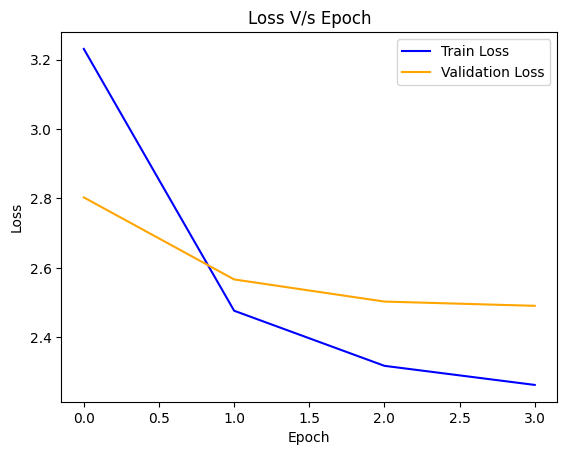

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(4)
train_loss = np.array(train_loss)
val_loss = np.array(val_loss)

plt.plot(x,train_loss,color='blue',label='Train Loss')
plt.plot(x,val_loss,color='orange',label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss V/s Epoch')
plt.show()

In [ ]:
# taken reference from https://adithyask.medium.com/a-beginners-guide-to-fine-tuning-gemma-0444d46d821c

def story_generator(query, model, tokenizer):
  device = "cpu"
  prompt_template = """<start_of_turn>
  user
  Below is an instruction that describes a task. Write a response that appropriately completes the request.
  {query}
  <end_of_turn>\\n<start_of_turn> model

  """
  temp = """
  user
  Below is an instruction that describes a task. Write a response that appropriately completes the request.
  {query}
  \\n model

  """
  prompt = prompt_template.format(query=query)
  new_temp = temp.format(query=query)
  # print(type(prompt))
  encoder = tokenizer(prompt, return_tensors="pt", add_special_tokens=True)
  model_inputs = encoder.to(device)
  generated_ids = model.generate(**model_inputs, max_new_tokens=500, do_sample=True, pad_token_id=tokenizer.eos_token_id)
  decoded = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
  # print(prompt)
  # print(new_temp)
  # print((decoded))
  # print(len(new_temp) == len(decoded[:200]))
  # print(decoded[:200])
  return (decoded)[len(new_temp):]

In [ ]:
# story_generator(query=actual[0], model=my_model, tokenizer=my_tokenizer)
# # print(a == c[:200])

'A family friend of mine used to work in private wealth management. One of her sons grew quite confident after the stock market began to recover after a bad year. The family has a large home with a beautiful view and a swimming pool. The kids are old enough to be able to swim though they are still a little scared of the pool. The father, a tall man who used to do more than his share about maintaining the lawn, has been feeling better lately. His work was a bit less demanding'

In [ ]:
import torch
import transformers

my_tokenizer = transformers.AutoTokenizer.from_pretrained("/content/drive/MyDrive/Story Generation Model Weights/horror_story/Gemma-Horror-Story-V1")
my_model = transformers.AutoModelForCausalLM.from_pretrained("/content/drive/MyDrive/Story Generation Model Weights/horror_story/Gemma-Horror-Story-V1")

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# prompt_template = """<start_of_turn>
# user
# Below is an instruction that describes a task. Write a response that appropriately completes the request.
# {query}
# <end_of_turn>\\n<start_of_turn> model

# """

In [ ]:
# prompt_template[:len(prompt_template)] == prompt_template

True

In [ ]:
actual = []
for i in range(len(testing_data)):
  actual.append('Generate a horror story given the beginning of the story: '+testing_data[i]['Prompt'])

In [ ]:
predicted = []
for i in range(len(testing_data)):
  print(i)
  predicted.append(story_generator(query=actual[i], model=my_model, tokenizer=my_tokenizer))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [ ]:
predicted[0]

'A family friend of mine used to work in private wealth management. One of her most memorable clients was a young man named Charles, who was born with the\n  disease. Despite the odds stacked against him, Charles defied the medical establishment. One day, he got a job teaching a young boy with Down Syndrome,\n   so that he could change his fortunes. That day a decision was made to change Charles fortunes. Charles was transferred to a big bank. Then he was assigned to work with a wealthy family. That was where I met Charles. What he lacked in years of hard work was compensated with wealth. Over time, the man earned a great deal of money, and eventually his net worth went up to an astonishing amount. And that’s where this story begins. It is about the man who changed Charles life. It is about a young boy who defied the odds. To understand why this story is unique, we need to follow through on what happened to Charles to see how it leads the man to a job at an investment bank. So here’s t

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00


In [ ]:
import evaluate


perplexity = evaluate.load("perplexity", module_type="metric")
results = perplexity.compute(model_id='/content/drive/MyDrive/Story Generation Model Weights/horror_story/Gemma-Horror-Story-V1', add_start_token=False,
                             predictions=predicted, device='cpu')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
print('Perplexity: ',results['perplexities'])
print('Mean Perplexity: ',results['mean_perplexity'])

Perplexity:  [13.277413368225098, 23.085153579711914, 25.713298797607422, 13.881441116333008, 55.19805145263672, 29.859989166259766, 37.965187072753906, 26.137847900390625, 31.45769691467285, 64.48236846923828, 40.76357650756836, 11.101465225219727, 34.209686279296875, 16.423856735229492, 33.63460159301758]
Mean Perplexity:  30.47944227854411


In [ ]:
# taken reference from NLP Assignment 3 Code Done by Shaina Mehta

def bleu_1(actual, predicts):
    decoded_actual = [act.strip() for act in actual]
    decoded_prediction = [pred.strip() for pred in predicts]
    bleu = evaluate.load("bleu")
    result = bleu.compute(predictions=decoded_prediction, references=decoded_actual, max_order=1)
    return result['bleu']

def bleu_2(actual, predicts):
    decoded_actual = [act.strip() for act in actual]
    decoded_prediction = [pred.strip() for pred in predicts]
    bleu = evaluate.load("bleu")
    result = bleu.compute(predictions=decoded_prediction, references=decoded_actual, max_order=2)
    return result['bleu']

def bleu_3(actual, predicts):
    decoded_actual = [act.strip() for act in actual]
    decoded_prediction = [pred.strip() for pred in predicts]
    bleu = evaluate.load("bleu")
    result = bleu.compute(predictions=decoded_prediction, references=decoded_actual, max_order=3)
    return result['bleu']

def bleu_4(actual, predicts):
    decoded_actual = [act.strip() for act in actual]
    decoded_prediction = [pred.strip() for pred in predicts]
    bleu = evaluate.load("bleu")
    result = bleu.compute(predictions=decoded_prediction, references=decoded_actual, max_order=4)
    return result['bleu']

In [ ]:
len(testing_data['Story'])

15

In [ ]:
true_values = []
for i in range(len(testing_data['Story'])):
  true_values.append(testing_data['Story'][i])

In [ ]:
print('BLEU 1 Score:',bleu_1(true_values, predicted))
print('BLEU 2 Score:',bleu_2(true_values, predicted))
print('BLEU 3 Score:',bleu_3(true_values, predicted))
print('BLEU 4 Score:',bleu_4(true_values, predicted))

BLEU 1 Score: 0.3097818019890159
BLEU 2 Score: 0.15963983213519858
BLEU 3 Score: 0.09817129544520443
BLEU 4 Score: 0.07301270232036362


# Human Evaluation

In [ ]:
prompt = 'Generate a horror story given the beginning of the story: '+ 'Two farmhands shared a room. One slept at the back of the room. The other slept near the door. After a while, the one who '
result = story_generator(query=prompt, model=my_model, tokenizer=my_tokenizer)
print(result)

Two farmhands shared a room. One slept at the back of the room. The other slept near the door. After a while, the one who slept at the back of the room jumped out of bed and ran to the door and pushed it open. He peered out and saw the farmer taking a trip down the 
room. Then, the two farmhands went to sleep again. The first farmer’s son dreamed that his father jumped out of bed and ran to the door and pushed it open. The two farmhands, one who slept at the back of the room and one who slept near the door slept soundly. 
 One man was about to sleep when the farmer’s son woke up and went to the door to get something. The first farmhand awoke and went to the door to push it open. The farmer’s son looked out the door and saw the first farmhand. Suddenly, the farmer’s son broke the door down. The door swung open and shut. Then, the first farmhand rushed through the door, and the farmer’s son went inside. 
Then, the farmer’s son went to the back of the room, and the second farmhand followe

In [ ]:
# from google.colab import files
# files.download('/content/Gemma-Adventure-Story-V1/model-00001-of-00002.safetensors')

In [ ]:
! git clone https://github.com/shaina-12/dump.git

In [ ]:
! cd dump

In [ ]:
! ls

In [ ]:
from flask import Flask

from flask import render_template, jsonify, redirect, url_for, request

app = Flask(__name__)

@app.route('/')
@app.route('/home')
def home_page():
    return render_template('index.html')

@app.route('/diagnose', methods=['GET','POST'])
def diagnose_page():
    if request.method == 'POST':
        file = request.files['file']
        img_path = "static/uploads/" + file.filename
        file.save(img_path)
        p = model_predict(img_path)
        return render_template('diagnosis.html', prediction_text=p, image_path = img_path)
    return render_template('diagnose.html')

@app.route('/team')
def team_page():
    return render_template('team.html')

if __name__ == '__main__':
    app.run(debug=True)